**URL :**

https://www.aarcorp.com/news/?F_All=y

In [1]:
#libraries
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random,textstat,urllib.request
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from selenium import webdriver
from tqdm.auto import tqdm

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

Autosaving every 1 seconds


In [2]:
#driver for operation
from webdriver_manager.firefox import GeckoDriverManager
driver = webdriver.Firefox(executable_path=GeckoDriverManager().install())



====== WebDriver manager ======
Current firefox version is 102.0
Get LATEST geckodriver version for 102.0 firefox
Driver [C:\Users\AKSHAY SATPUTE\.wdm\drivers\geckodriver\win64\v0.31.0\geckodriver.exe] found in cache


In [3]:
#site name ,domain , site link
SITE_NAME='aarcorp'

DOMAIN = "https://www.aarcorp.com/"

SITE_LINK = "https://www.aarcorp.com/news/?F_All=y"

In [4]:
#functions
def remove_esc_chars(string):
    review = re.sub('''[^a-zA-Z0-9!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~°]''', ' ',string)
    review = review.split()
    review = ' '.join(review)
    return review

def get_text_thumb(link): 
    try:
        driver.get(link)
        thumb = "https://www.aarcorp.com/cms/images/layout/printlogo.png"
        ps = driver.find_element(By.XPATH,'''//*[@id="main"]/main/section''').text.strip()
        text = remove_esc_chars(ps).strip()
    except:
        thumb = "https://www.aarcorp.com/cms/images/layout/printlogo.png"
        g = Goose()
        article_extract = g.extract(url=link)
        article = remove_esc_chars(article_extract.cleaned_text)
        meta_data = remove_esc_chars(article_extract.meta_description)
        whole_data = meta_data+article
        text = whole_data.strip()

        if textstat.lexicon_count(text, removepunct=True) < 5:
            try:
                response = requests.get(link)
                text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

                if textstat.lexicon_count(text, removepunct=True) < 5:
                    texts = ""
                    r = requests.get(link)
                    filename = Path('temp.pdf')
                    filename.write_bytes(r.content)

                    pages = convert_from_path('temp.pdf', 500)
                    for x in pages:
                        x.save("temp.jpg")
                        output = reader.readtext("temp.jpg")
                        for o in output:
                            texts += o[1]

                    text = remove_esc_chars(texts)

                    if textstat.lexicon_count(text, removepunct=True) < 5:
                        texts = ""
                        soup = parse_webpage_bs(link)
                        if soup!= None:
                            ps = soup.findAll('p')
                            for p in ps:
                                texts+= p.text

                        text = remove_esc_chars(texts)
            except:
                text = ""
    
    return text , thumb

In [5]:
#get data
article_list = []

# get url 
url = SITE_LINK
driver.get(url)
driver.maximize_window()
time.sleep(3)

#accept cookies
try: 
    driver.find_element(By.XPATH,f'''/html/body/div[1]/div[1]/div/a''').click()
except:
    pass

#elements
elements = driver.find_elements(By.XPATH,'''//*[@id="CT_Main_0_pnPage"]/div[2]/div/div''')

#creating empty lists to append data 
published_dates,titles,texts,links,thumbnails,authors = [],[],[],[],[],[]

#published_dates,titles,links,authors
for e in tqdm(range(1,len(elements[:])+1),desc = "Gathering primary data"):
    try:
        published_date = driver.find_element(By.XPATH,f'''/html/body/form/main/section/div/div/div[2]/div/div[{e}]/div[2]/span''').text.strip()
        title = driver.find_element(By.XPATH,f'''/html/body/form/main/section/div/div/div[2]/div/div[{e}]/div[2]/h2/a''').text.strip()
        link = driver.find_element(By.XPATH,f'''/html/body/form/main/section/div/div/div[2]/div/div[{e}]/div[2]/h2/a''').get_attribute("href")
        author = SITE_NAME    

        published_dates.append(published_date)
        titles.append(title)
        links.append(link)
        authors.append(author)   
    except:
        pass

#texts,thumbnails
for link in tqdm(links[-10:],desc="Getting articles"):
    text,thumbnail = get_text_thumb(link)
    texts.append(text)
    thumbnails.append(thumbnail)
    

#zippig all the data togather 
zipped = list(zip(published_dates,titles,texts,links,thumbnails,authors))

#unwinding and appending to the main list
for published_date,title,text,link,thumbnail,author in zipped:
    article = (published_date.strip(),title.strip(),text.strip(),link.strip(),thumbnail.strip(),author.strip())
    article_list.append(article)
    print(published_date,title)
    

Gathering primary data:   0%|          | 0/302 [00:00<?, ?it/s]

Getting articles:   0%|          | 0/10 [00:00<?, ?it/s]

Jul 05, 2022 AAR’S COMPONENT REPAIR FACILITY IN AMSTERDAM RANKED NO. 1 OUTSTANDING SOURCE OF REPAIR BY NATO SUPPORT AND PROCUREMENT AGENCY FOR FIFTH TIME
Apr 27, 2022 AAR’S LANDING GEAR PBL PROGRAM WINS 2021 SECRETARY OF DEFENSE PBL AWARD
Apr 26, 2022 AAR ANNOUNCES MARKETING PARTNERSHIP AGREEMENT WITH PROVENAIR TECHNOLOGIES, LLC
Mar 22, 2022 AAR REPORTS THIRD QUARTER FISCAL YEAR 2022 RESULTS
Mar 14, 2022 AAR SIGNS EXCLUSIVE DISTRIBUTION AGREEMENT WITH COLLINS AEROSPACE’S GOODRICH DE-ICING & SPECIALTY HEATING SYSTEMS BUSINESS
Mar 08, 2022 AAR TO ANNOUNCE THIRD QUARTER FISCAL YEAR 2022 RESULTS ON MARCH 22, 2022
Feb 15, 2022 AAR NAMED AMONG AMERICA’S BEST MIDSIZE EMPLOYERS FOR 2022 BY FORBES
Feb 10, 2022 AAR TO PARTICIPATE IN CITI'S 2022 GLOBAL INDUSTRIAL TECH AND MOBILITY CONFERENCE ON FEBRUARY 23, 2022
Feb 09, 2022 RVC AVIATION MAINTENANCE STUDENTS LAUNCH THEIR CAREER WITH AAR
Feb 07, 2022 AAR ANNOUNCES A 10-YEAR EXTENSION OF ITS COMPONENT MRO AGREEMENT WITH IAMCO FOR SUPPORT OF THE NAT

In [6]:
#temp df
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df.head()

,date,title,article,url,thumbnail,author
0,"Jul 05, 2022",AAR’S COMPONENT REPAIR FACILITY IN AMSTERDAM R...,AAR Reports Fourth Quarter and Fiscal Year 201...,https://www.aarcorp.com/aarscomponentrepairfac...,https://www.aarcorp.com/cms/images/layout/prin...,aarcorp
1,"Apr 27, 2022",AAR’S LANDING GEAR PBL PROGRAM WINS 2021 SECRE...,AAR s Nordisk Aviation Products Selected by Ch...,https://www.aarcorp.com/aar-landing-gear-pbl-p...,https://www.aarcorp.com/cms/images/layout/prin...,aarcorp
2,"Apr 26, 2022",AAR ANNOUNCES MARKETING PARTNERSHIP AGREEMENT ...,AAR Earns Nadcap Accreditation for Composites ...,https://www.aarcorp.com/aar-announces-marketin...,https://www.aarcorp.com/cms/images/layout/prin...,aarcorp
3,"Mar 22, 2022",AAR REPORTS THIRD QUARTER FISCAL YEAR 2022 RES...,AAR to Announce Fourth Quarter and Fiscal Year...,https://www.aarcorp.com/aar-reports-third-quar...,https://www.aarcorp.com/cms/images/layout/prin...,aarcorp
4,"Mar 14, 2022",AAR SIGNS EXCLUSIVE DISTRIBUTION AGREEMENT WIT...,AAR Operations Commence in Central Africa July...,https://www.aarcorp.com/aarsignsexclusivedistr...,https://www.aarcorp.com/cms/images/layout/prin...,aarcorp


Feb 07, 2022 AAR ANNOUNCES A 10-YEAR EXTENSION OF ITS COMPONENT MRO AGREEMENT WITH IAMCO FOR SUPPORT OF THE NATO E-3A AIRBORNE WARNING AND CONTROL (AWACS) FLEET

aarcorp https://www.aarcorp.com/aar-announces-a-10-year-extension-of-its-component-mro-agreement-with-iamco-for-support-of-the-nato-e-3a-airborne-warning-and-control-awacs-fleet/?F_All=y


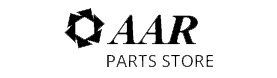


AAR Becomes the First MRO Operator to Sign Data-Sharing Pact with FAA June 6, 2014 Leader in aircraft maintenance takes steps to ensure aviation safety, identify risks WOOD DALE, Illinois, June 6, 2014 -- AAR (NYSE: AIR), a recognized leader in aircraft maintenance, repair and overhaul (MRO), has become the first MRO operator to agree to voluntarily share safety information with the Federal Aviation Administration. AAR recently signed an agreement to take part in the FAA s Aviation Safety Information Analysis and Sharing program (ASIAS), which is designed to help MRO operators avoid serious and potentially costly safety issues and the FAA to identify high-risk areas. The FAA is very pleased to have AAR launch the ASIAS program among MROs, said Steven Douglas, Manager, Aircraft Maintenance Division, for the FAA. We believe that sharing and analyzing safety data are important for the aviation industry as a whole. Safety and performance are the cornerstones of AAR s 1MRO Network, compris

In [7]:
#see data
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    urllib.request.urlretrieve(temp_df.iloc[iloc_no]['thumbnail'], "temp.jpg")
    display(Image.open("temp.jpg"))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [8]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [9]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        try:
            os.remove("temp.pdf")
        except:
            pass
        os.remove("temp.jpg")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

Trash removed successfully
